<a href="https://colab.research.google.com/github/khongpan/DurianIrrigation/blob/main/CWSI_00001_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#@title Mount Storage and Import Library
#if running on google colab, mount google drive for custom lib.
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/gdrive/')
  import sys
  notebook_path='/content/gdrive/MyDrive/Colab Notebooks'
  if (notebook_path not in sys.path) :
    sys.path.append(notebook_path)
  #print(sys.path)
  #print('Running on CoLab')
  pass
else:
  #print('Not running on CoLab')
  pass

#import nescessary lib module
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from lib.agritronics import *
from lib.et import *
from lib.dataman import *

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [30]:
#@title Setup Parameters 
#x axis for time in graph
time_np = np.arange(0,24,24/288) 

# data interval to use 
sampling_period_in_sec = 60*5 

#number of sampling per day
sampling_per_day = 24.0*60*60/sampling_period_in_sec

#number of average point for smooting data
moving_avg_point = 3 

#range of day to do our job
start_date=dt.datetime.strptime('2020/09/02','%Y/%m/%d') #start date
#end_date = start_date
end_date=dt.datetime.strptime('2021/02/20','%Y/%m/%d') #end date

#minimum soil moisture level that plant still take as much as water its require
wet_soil_threshold = 0.3


In [ ]:
#@title Download Data

#init varible we use
all_tc_np = np.array([])
all_ta_np = np.array([])
all_rh_np = np.array([])
all_sm_np = np.array([])
all_td_np = np.array([])
all_vpd_np = np.array([])
all_time_np = np.array([])
all_wet_soil_flag_np = np.array([])

def DownloadData() :
  global time_s,tc_s,ta_s,rh_s,sm_s
  time_s,tc_s = GetDailyData('TEST-DURIAN-01-WT',F'{0x1300}','1214',date.strftime("%Y-%m-%d"))
  if(len(time_s)<sampling_per_day*0.9) :
    return False
  tc_s=ReSamplingDailyData(time_s, tc_s,sampling_period_in_sec)

  time_s,ta_s=GetDailyData('TEST-DURIAN-01-WT','4096','1',date.strftime("%Y-%m-%d"))
  if(len(time_s)<sampling_per_day*0.9) :
    return False
  ta_s=ReSamplingDailyData(time_s, ta_s,sampling_period_in_sec)

  time_s,rh_s = GetDailyData('TEST-DURIAN-01-WT','4096','2',date.strftime("%Y-%m-%d"))
  if(len(time_s)<sampling_per_day*0.9) :
    return False
  rh_s= ReSamplingDailyData(time_s, rh_s,sampling_period_in_sec)

  time_s,sm_s = GetDailyData('TEST-DURIAN-01-WT',F'{0x1300}','1100',date.strftime("%Y-%m-%d"))
  if(len(time_s)<sampling_per_day*0.9) :
    return False
  sm_s = ReSamplingDailyData(time_s, sm_s,sampling_period_in_sec)
  
  return True

def PreprocessingData() :
  global tc_np,ta_np,rh_np,sm_np
  tc_np = m_avg(np.array(tc_s),moving_avg_point)
  ta_np = m_avg(np.array(ta_s),moving_avg_point)
  rh_np = m_avg(np.array(rh_s),moving_avg_point)
  sm_np = np.array(sm_s)
  return

#this is main program to download data
date = start_date
while date<=end_date:
  
  date_str = date.strftime('%Y/%m/%d')

  #download daily data
  if DownloadData()==False :
    date=date+dt.timedelta(days=1)
    print(F'{date_str} data incomplete')
    continue

  #preprocessing data eg. smoothing
  PreprocessingData()

  #calculate some parameters from downloaded data
  td_np = tc_np-ta_np
  vpd_np = CalcVPD(ta_np,rh_np)
  wet_soil_flag_np = np.full(len(sm_np) ,sm_np.min()>wet_soil_threshold)

  #append downloaded data
  all_time_np = np.append(all_time_np, time_np)
  all_td_np = np.append(all_td_np, td_np)
  all_rh_np = np.append(all_rh_np,rh_np)
  all_vpd_np = np.append(all_vpd_np,vpd_np)
  all_wet_soil_flag_np = np.append(all_wet_soil_flag_np,wet_soil_flag_np)


  daily_td_max = np.max(td_np)
  print(F'{date_str} max Tc-Ta {daily_td_max:.2f}     ')
  #print('.',end='')

  #keep going to next day
  date=date+dt.timedelta(days=1)


All time maximum Tc-Ta 2.17 form 48672 data points


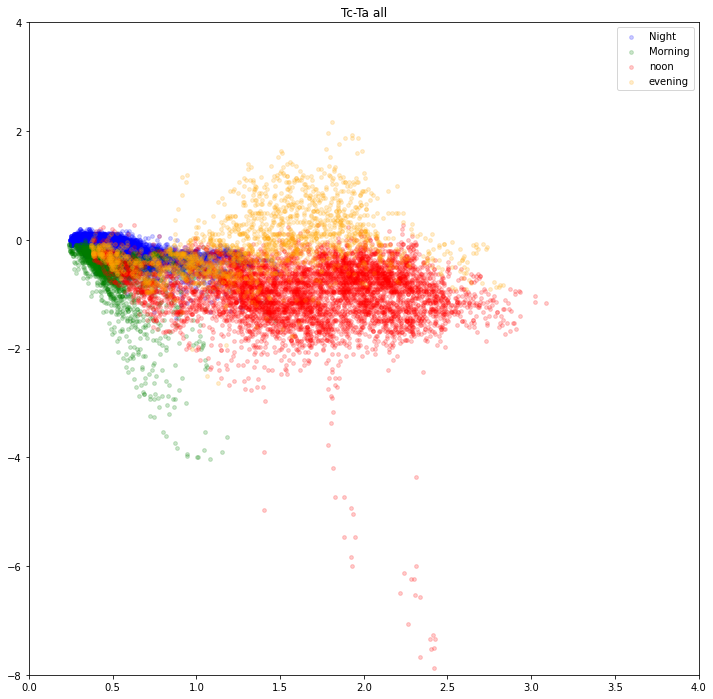

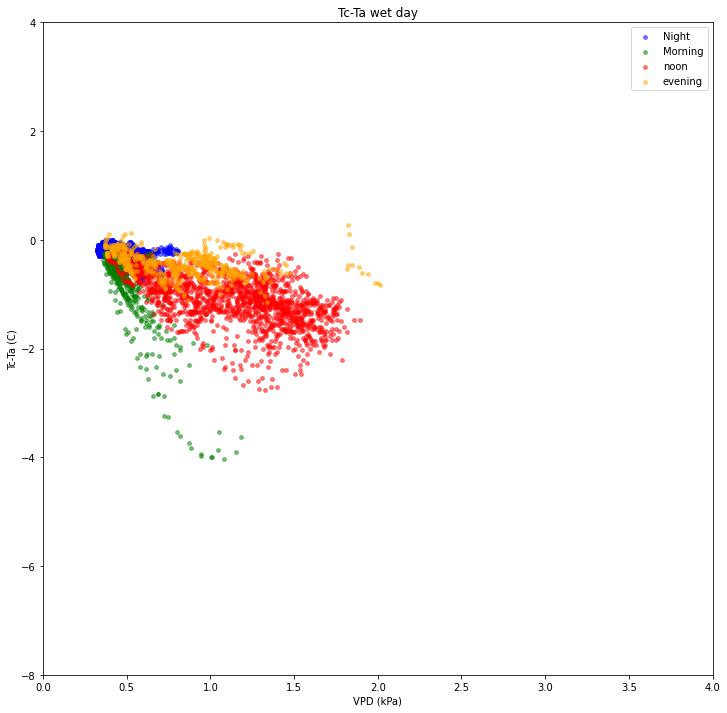

In [36]:
#@title Select Data to Plot
all_td_max= np.max(all_td_np)
print(F'All time maximum Tc-Ta {all_td_max:.2f} form {len(all_td_np)} data points')

#grouping data by time
night_np = np.logical_or(all_time_np<=5, all_time_np>=20)
morning_np = np.logical_and(all_time_np>=7, all_time_np<8)
noon_np = np.logical_and(all_time_np>=11, all_time_np<14)
evening_np = np.logical_and(all_time_np>=16, all_time_np<17)

plt.rcParams['figure.figsize'] = [12, 12]
fig,ax = plt.subplots()
ds=14
alpha=0.2
ax.set_title('Tc-Ta all')

ax.scatter(all_vpd_np[night_np],all_td_np[night_np],label='Night',s=ds,c='b',alpha=alpha)
ax.scatter(all_vpd_np[morning_np],all_td_np[morning_np],label='Morning',s=ds,c='g',alpha=alpha)
ax.scatter(all_vpd_np[noon_np],all_td_np[noon_np],label='noon',s=ds,c='r',alpha=alpha)
ax.scatter(all_vpd_np[evening_np],all_td_np[evening_np],label='evening',s=ds,c='orange',alpha=alpha)
ax.set(xlim=(0,4),ylim=(-8,4))
ax.legend()
plt.show()

#select only wet soil day
wet_night_np = np.logical_and(night_np, all_wet_soil_flag_np)
wet_morning_np = np.logical_and(morning_np,all_wet_soil_flag_np)
wet_noon_np = np.logical_and(noon_np,all_wet_soil_flag_np)
wet_evening_np = np.logical_and(evening_np,all_wet_soil_flag_np)

plt.rcParams['figure.figsize'] = [12, 12]
fig,ax = plt.subplots()
ds=14
alpha=0.5
ax.set_title("Tc-Ta wet day")
ax.set_xlabel('VPD (kPa)')
ax.set_ylabel('Tc-Ta (C)')
ax.scatter(all_vpd_np[wet_night_np],all_td_np[wet_night_np],label='Night',s=ds,c='b',alpha=alpha)
ax.scatter(all_vpd_np[wet_morning_np],all_td_np[wet_morning_np],label='Morning',s=ds,c='g',alpha=alpha)
ax.scatter(all_vpd_np[wet_noon_np],all_td_np[wet_noon_np],label='noon',s=ds,c='r',alpha=alpha)
ax.scatter(all_vpd_np[wet_evening_np],all_td_np[wet_evening_np],label='evening',s=ds,c='orange',alpha=alpha)
ax.set(xlim=(0,4),ylim=(-8,4))
ax.legend()
plt.show()


